In [1]:
import os
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=gpu0,floatX=float32,optimizer=fast_compile,exception_verbosity=high'

In [2]:

from __future__ import absolute_import
from __future__ import print_function
import pylab as pl
import matplotlib.cm as cm
import itertools
import numpy as np
import theano.tensor as T
np.random.seed(1337) # for reproducibility

from keras.datasets import mnist
#import keras.layers.containers as containers
from keras.layers.noise import GaussianNoise
import keras.models as models
#import keras.layers.containers as containers
from keras.layers import Input
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Merge, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.regularizers import ActivityRegularizer

from keras import backend as K

import cv2
import numpy as np

path = './CamVid/'
data_shape = 360*480

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
Using Theano backend.


## Data Fetching 
I equalized histograms of rbg layers separately, so that change in lighting doesnt effect the results.

In [74]:
import numpy as np
import keras
import cv2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
def normalized(rgb):
    #return rgb/255.0
    norm=np.zeros((rgb.shape[0], rgb.shape[1], 3),np.float32)

    b=rgb[:,:,0]
    g=rgb[:,:,1]
    r=rgb[:,:,2]

    norm[:,:,0]=cv2.equalizeHist(b)
    norm[:,:,1]=cv2.equalizeHist(g)
    norm[:,:,2]=cv2.equalizeHist(r)

    return norm

def binarylab(labels):
    x = np.zeros([360,480,12])    
    for i in range(360):
        for j in range(480):
            x[i,j,labels[i][j]]=1
    return x

def prep_data():
    train_data = []
    train_label = []
    import os
    with open(path+'train.txt') as f:
        txt = f.readlines()
        txt = [line.split(' ') for line in txt]
    for i in range(len(txt)-200):
        ## these paths are very specific to my machine
        temp = np.zeros((12,360,480))
        train_data.append(np.rollaxis(normalized(cv2.imread(os.getcwd() + txt[i][0][7:])),2))
        temp[0,:,:] = binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0])[:,:,0]
        temp[1,:,:] = binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0])[:,:,1]
        temp[2,:,:] = binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0])[:,:,2]
        temp[3,:,:] = binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0])[:,:,3]
        temp[4,:,:] = binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0])[:,:,4]
        temp[5,:,:] = binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0])[:,:,5]
        temp[6,:,:] = binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0])[:,:,6]
        temp[7,:,:] = binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0])[:,:,7]
        temp[8,:,:] = binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0])[:,:,8]
        temp[9,:,:] = binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0])[:,:,9]
        temp[10,:,:] = binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0])[:,:,10]
        temp[11,:,:] = binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0])[:,:,11]
        train_label.append(temp)
        print('.',end='')
    return np.array(train_data), np.array(train_label)

train_data, train_label = prep_data()
#train_label = np.reshape(train_label,(7,data_shape,12))

.........

KeyboardInterrupt: 

In [3]:
def normalized(rgb):
    #return rgb/255.0
    norm=np.zeros((rgb.shape[0], rgb.shape[1], 3),np.float32)

    b=rgb[:,:,0]
    g=rgb[:,:,1]
    r=rgb[:,:,2]

    norm[:,:,0]=cv2.equalizeHist(b)
    norm[:,:,1]=cv2.equalizeHist(g)
    norm[:,:,2]=cv2.equalizeHist(r)

    return norm

def binarylab(labels):
    x = np.zeros([360,480,12])
    for i in range(360):
        for j in range(480):
            x[i,j,labels[i][j]]=1
    return x

def prep_data():
    train_data = []
    train_label = []
    import os
    with open(path+'train.txt') as f:
        txt = f.readlines()
        txt = [line.split(' ') for line in txt]
    for i in range(len(txt)):
        train_data.append(np.rollaxis(normalized(cv2.imread(os.getcwd() + txt[i][0][7:])),2))
        train_label.append(binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0]))
        print('.',end='')
    return np.array(train_data), np.array(train_label)

train_data, train_label = prep_data()
train_label = np.reshape(train_label,(367,data_shape,12))

class_weighting= [0.2595, 0.1826, 4.5640, 0.1417, 0.5051, 0.3826, 9.6446, 1.8418, 6.6823, 6.2478, 3.0, 7.3614]

...............................................................................................................................................................................................................................................................................................................................................................................

In [4]:
train_label.shape

(367, 172800, 12)

In [5]:

# class weigths
class_weighting= [0.2595, 0.1826, 4.5640, 0.1417, 0.9051, 0.3826, 9.6446, 1.8418, 6.6823, 6.2478, 3.0, 7.3614]


In [6]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, UpSampling2D, Reshape, Permute, Input, merge
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Model
inputs = Input(((3,360,480)))
zeropad1 = ZeroPadding2D(padding=(1,1))(inputs)
conv1 = Convolution2D(64, 3, 3, border_mode='valid')(zeropad1)
batch1 = conv1#BatchNormalization(axis=1)(conv1)
act1 = Activation('relu')(batch1)
maxpool1 = MaxPooling2D(pool_size=(2,2))(act1) #64,204,220

zeropad2 = ZeroPadding2D(padding=(1,1))(maxpool1)
conv2 = Convolution2D(128, 3, 3, border_mode='valid')(zeropad2)
batch2 = conv2#BatchNormalization(axis=1)(conv2)
act2 = Activation('relu')(batch2)
maxpool2 = MaxPooling2D(pool_size=(2,2))(act2) #128,102,110

zeropad3 = ZeroPadding2D(padding=(1,1))(maxpool2)
conv3 = Convolution2D(256, 3, 3, border_mode='valid')(zeropad3)
batch3 = conv3#BatchNormalization(axis=1)(conv3)
act3 = Activation('relu')(batch3)
maxpool3 = MaxPooling2D(pool_size=(2,2))(act3) #256,51,55

zeropad4 = ZeroPadding2D(padding=(1,1))(maxpool3)
conv4 = Convolution2D(256, 3, 3, border_mode='valid')(zeropad4) #256,51,55
batch4 = conv4#BatchNormalization(axis=1)(conv4)

upsamp1 = merge([UpSampling2D(size=(2,2))(batch4), conv3], mode='concat', concat_axis=1)
zeropad5 = ZeroPadding2D(padding=(1,1))(upsamp1)
conv5 = Convolution2D(128, 3, 3, border_mode='valid')(zeropad5) #256,102,110
batch5 = conv5#BatchNormalization(axis=1)(conv5)

#upsamp2 = UpSampling2D(size=(2,2))(conv5)
upsamp2 = merge([UpSampling2D(size=(2,2))(batch5), conv2], mode='concat', concat_axis=1)
zeropad6 = ZeroPadding2D(padding=(1,1))(upsamp2)
conv6 = Convolution2D(128, 3, 3, border_mode='valid')(zeropad6)
batch6 = conv6#BatchNormalization(axis=1)(conv6)

upsamp3 = merge([UpSampling2D(size=(2,2))(batch6), conv1], mode='concat', concat_axis=1)
zeropad7 = ZeroPadding2D(padding=(1,1))(upsamp3)
conv7 = Convolution2D(64, 3, 3, border_mode='valid')(zeropad7)

conv8 = Convolution2D(12, 1, 1, border_mode='valid')(conv7)
reshape1 = Reshape((12,360*480))(conv8)
permute1 = Permute((2, 1))(reshape1)
finalact = Activation('softmax')(permute1)

modelcai = Model(input=inputs, output=finalact)

In [7]:
from keras.optimizers import SGD
from keras import backend as K
from keras.optimizers import Adam
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
sgd = SGD(lr=0.0001, momentum=1.5)
modelcai.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adadelta')
#modelcai.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

In [8]:
modelcai.layers[29].output_shape

(None, 172800, 12)

Visualizing autoencoder

## Training 
At the end of 100 epochs training acc was about 0.91

#### Epoch 100/100

367/367 [==============================] - 890s - loss: 0.2942 - acc: 0.9100   


In [9]:
modelcai.load_weights('weights_crossent_79pc')

In [19]:
nb_epoch = 10
batch_size = 5

modelcai.fit(train_data, train_label, batch_size=batch_size, nb_epoch=nb_epoch, verbose=True, class_weight=class_weighting,shuffle=True, validation_split=0.2 )#, validation_data=(X_test, X_test))
#print history
#autoencoder.save_weights('model_weight_ep100.hdf5')

#score = autoencoder.evaluate(X_test, X_test, show_accuracy=True, verbose=0)
#print('Test score:', score[0])
#print('Test accuracy:', score[1]) 

Train on 293 samples, validate on 74 samples
Epoch 1/10
293/293 [==============================] - 172s - loss: 2.2835 - acc: 0.8576 - val_loss: 2.9287 - val_acc: 0.8176
Epoch 2/10
293/293 [==============================] - 172s - loss: 2.3666 - acc: 0.8524 - val_loss: 2.9422 - val_acc: 0.8167
Epoch 3/10
293/293 [==============================] - 172s - loss: 2.2405 - acc: 0.8603 - val_loss: 2.8157 - val_acc: 0.8247
Epoch 4/10
293/293 [==============================] - 172s - loss: 2.4101 - acc: 0.8497 - val_loss: 3.3162 - val_acc: 0.7937
Epoch 5/10
293/293 [==============================] - 172s - loss: 2.1888 - acc: 0.8635 - val_loss: 3.7845 - val_acc: 0.7641
Epoch 6/10
293/293 [==============================] - 172s - loss: 2.3792 - acc: 0.8517 - val_loss: 2.8974 - val_acc: 0.8196
Epoch 7/10
293/293 [==============================] - 172s - loss: 2.1280 - acc: 0.8674 - val_loss: 3.4927 - val_acc: 0.7824
Epoch 8/10
293/293 [==============================] - 172s - loss: 2.2335 - acc:

In [9]:
modelcai.load_weights('weights_crossent_83pc')

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road_marking = [255,69,0]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

label_colours = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

def visualize(temp, plot=True):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,11):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
    else:
        return rgb

In [12]:
import os

gt = []
with open(path+'train.txt') as f:
    txt = f.readlines()
    txt = [line.split(' ') for line in txt]
for i in range(len(txt)):
    gt.append(cv2.imread(os.getcwd() + txt[i][0][7:]))

(1, 3, 360, 480)


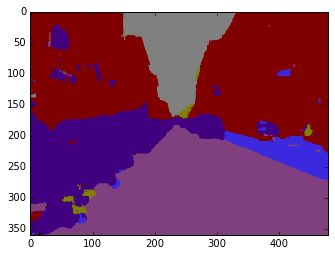

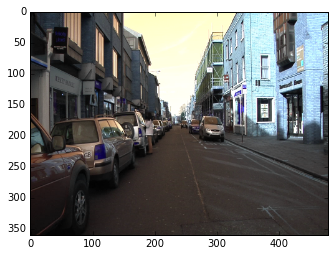

In [18]:
print(train_data[301:302].shape)
output = modelcai.predict(train_data[301:302])
output
pred = visualize(np.argmax(output[0],axis=1).reshape((360,480)), False)
plt.imshow(pred)
plt.figure(2)
plt.imshow(gt[301])